In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
#from matplotlib import rc
import pandas as pd
import statsmodels.api as sm
import importlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

#rc('font',**{'family':'serif'})
#rc('text', usetex=True)

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0 = Masses['A'].to_numpy()
Z0 = Masses['Z'].to_numpy()
N0 = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies0 = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc0 = Masses['E_unc'].to_numpy()


In [3]:
# select spaced energies over interval

start = 20
step = 10
stop = 258

Energies = Energies0[start:stop:step]
Energies_unc = Energies_unc0[start:stop:step]
A = A0[start:stop:step]
Z = Z0[start:stop:step]
N = N0[start:stop:step]

print(len(A))

24


In [4]:
ndim = 6

In [5]:
# define parameter space


theta_0_bound = np.array([4, 5]).reshape(1,-1)
theta_1_bound = np.array([-0.25, -0.15]).reshape(1,-1)
theta_2_bound = np.array([0.8, 1.1]).reshape(1,-1)
theta_3_bound = np.array([0.006, 0.009]).reshape(1,-1) # keep
theta_4_bound = np.array([0.25, 0.4]).reshape(1,-1)
theta_5_bound = np.array([-0.1, 0.1]).reshape(1,-1)


parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound, theta_5_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)



theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[3,0], parameter_bounds[3,1], 100)
theta_4_vals = np.linspace(parameter_bounds[4,0], parameter_bounds[4,1], 100)
theta_5_vals = np.linspace(parameter_bounds[5,0], parameter_bounds[5,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1), theta_4_vals.reshape(1,-1), theta_5_vals.reshape(1,-1)), axis=0)


In [6]:
def LiquidDropModel(A, Z, N, **parameters):
    
    indep_var = [1, A, (A**(2.0/3.0)), Z*(Z-1)*(A**(-1.0/3.0)), \
                 ((N-Z)**2)/A, ( (-1)**Z + (-1)**N )*(2*A**(-0.5))]
    
    E_B = 0
    
    for i in range(len(parameters)):
        E_B += parameters[i]*indep_var[i]
    
    return E_B


def LiquidDropModelTrue(a0, a1, a2, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0))


In [7]:
indep_var = [1, A, (A**(2.0/3.0)), Z*(Z-1)*(A**(-1.0/3.0)), \
                 ((N-Z)**2)/A, ( (-1)**Z + (-1)**N )*(0.5*A**(-0.5))]

def design_matrix(ndim):
    # design matrix X
    X = np.zeros((len(A),ndim))
    for i in range(ndim):
        X[:,i] = indep_var[i]
    return X



X3d = np.zeros((len(A),3))
for i in range(3):
    X3d[:,0] = np.ones_like(A)
    X3d[:,1] = A
    X3d[:,2] = A**(2.0/3.0)
    

X2 = np.zeros((len(A),ndim))
for i in range(ndim):
    X2[:,1] = A
    X2[:,2] = A**(2.0/3.0)
    X2[:,3] = Z*(Z-1) * A**(-1.0/3.0)

In [8]:
clf_3d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(3), Energies)

clf_4d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(4), Energies)

clf_5d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(5), Energies)

clf_6d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(6), Energies)

clf_3d2 = skl.LinearRegression(fit_intercept=False).fit(X2, Energies)

print('3D coefficients : ' + str(clf_3d.coef_))
print('4D coefficients : ' + str(clf_4d.coef_))
print('5D coefficients : ' + str(clf_5d.coef_))
print('6D coefficients : ' + str(clf_6d.coef_))
preds_6d = clf_6d.predict(design_matrix(6))
preds_5d = clf_5d.predict(design_matrix(5))
preds_4d = clf_4d.predict(design_matrix(4))
preds_3d = clf_3d.predict(X3d)

preds_3d2 = clf_3d2.predict(X2)

err3d = np.sum(np.square(Energies-preds_3d))
err4d = np.sum(np.square(Energies-preds_4d))
err5d = np.sum(np.square(Energies-preds_5d))
err6d = np.sum(np.square(Energies-preds_6d))

pred_sigmas = [np.sqrt(err3d / (len(Energies) - 3)), np.sqrt(err4d / (len(Energies) - 4)), \
                np.sqrt(err5d / (len(Energies) - 5)), np.sqrt(err6d / (len(Energies) - 6))]
#pred_sigma = np.sqrt(np.var(err))
pred_sigma_6d = np.sqrt(err6d / (len(Energies) - 6))
pred_sigma_5d = np.sqrt(err5d / (len(Energies) - 5))
pred_sigma_4d = np.sqrt(err4d / (len(Energies) - 4))
pred_sigma_3d = np.sqrt(err3d / (len(Energies) - 3))

print('3D sigma_model : ' + str(pred_sigma_3d) )
print('4D sigma_model : ' + str(pred_sigma_4d) )
print('5D sigma_model : ' + str(pred_sigma_5d) )
print('6D sigma_model : ' + str(pred_sigma_6d) )

3D coefficients : [ 7.88581447 -0.02707252  0.15899617]
4D coefficients : [ 7.78603062e+00 -3.25028320e-02  1.83150672e-01  3.29653624e-04]
5D coefficients : [ 6.51877771e+00 -1.07263193e-01  5.15627103e-01  3.67510043e-03
  1.49545705e-01]
6D coefficients : [ 1.15602956e+01 -4.78145122e-03 -5.30051102e-02 -2.52866860e-05
  6.66870210e-03 -1.32082979e+01]
3D sigma_model : 0.047507673245781305
4D sigma_model : 0.0466632305165185
5D sigma_model : 0.02790233475509084
6D sigma_model : 0.025562753797564303


Text(0.5, 1.0, '24 Output Predictions, 6D Model (aV,aS,aC)')

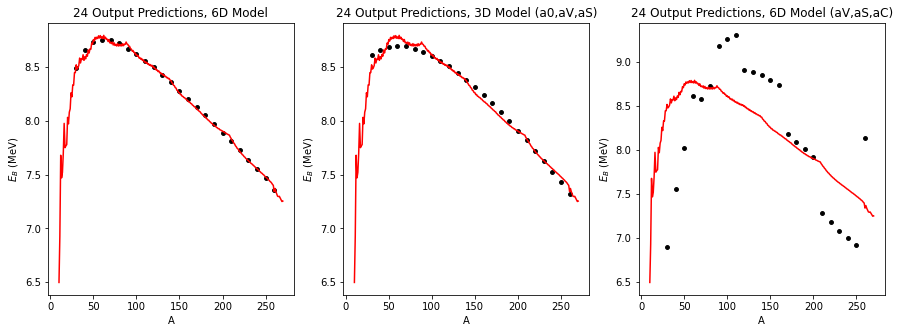

In [9]:
# check for most important active variables


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.scatter(A, preds_6d, color='black', s=15)
ax1.plot(A0, Energies0, color='red')
ax1.set_xlabel('A')
ax1.set_ylabel(r'$E_{B}$ (MeV)')
ax1.set_title('24 Output Predictions, 6D Model')

ax2.scatter(A, preds_3d, color='black', s=15)
ax2.plot(A0, Energies0, color='red')
ax2.set_xlabel('A')
ax2.set_ylabel(r'$E_{B}$ (MeV)')
ax2.set_title('24 Output Predictions, 3D Model (a0,aV,aS)')

ax3.scatter(A, preds_3d2, color='black', s=15)
ax3.plot(A0, Energies0, color='red')
ax3.set_xlabel('A')
ax3.set_ylabel(r'$E_{B}$ (MeV)')
ax3.set_title('24 Output Predictions, 6D Model (aV,aS,aC)')


In [10]:
variances = []
for i in range(4):
    variances.append(np.mean(Energies_unc)**2 + pred_sigmas[i]**2)

print(variances)

[0.0022569791012557027, 0.002177457166265521, 0.0007785403688129281, 0.000653454465742666]


In [11]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [12]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [13]:
A_matrices = []
b = []

for i in range(4):
    A_matrices.append(A_matrix(design_matrix(i+3), variances[i]))
    b.append(Energies / np.sqrt(variances[i]))


#A3d = A_matrix(X3d, variance)
#b = Energies / np.sqrt(variance)


In [14]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [15]:
thetas = []
for i in range(4):
    thetas.append(solve_theta(A_matrices[i], b[i]))

In [16]:
H_matrices = []

for i in range(4):
    H_matrices.append(H_matrix(A_matrices[i]))
    


In [17]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * np.sqrt(5.991) * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [18]:
def plot_ellipses(fig, parameter_bounds, H, theta_best, theta_vals, color):
    theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{A}$', r'$a_{P}$']
    
    
    N = len(theta_best)
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                ax.axis('off')
                #ax_right = ax.twinx()
                #ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                #if i == 3:
                    #ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                   #str(round(np.sqrt(H[i,i]),4)), fontsize=14)
                #else:
                    #ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                       #str(round(np.sqrt(H[i,i]),3)), fontsize=14)
                
            elif i < j:
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                #ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                #zax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
            else:
                ax.axis('off')
                
    plt.tight_layout()

In [19]:
color_list = ['black', 'plum', 'mediumaquamarine', 'red']
N = ndim
#fig, axes = plt.subplots(N,N,figsize=(15,15))

#plot_ellipses(fig, parameter_bounds, theta, H1, theta, theta_vals, color_list[0])
#fig.suptitle(r'Analytical Likelihood (95% Isoprobability Surface)')
#plt.savefig('figures/LD_analytical.png', bbox_inches='tight', facecolor='white', transparent=False)

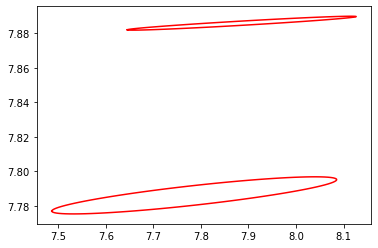

In [20]:
fig, ax = plt.subplots()
for k in range(2):
    H = H_matrices[k]
    cov_matrix = np.array([[H[0,0], H[0,1]],[H[1,0], H[1,1]]])
    get_cov_ellipse(cov_matrix, [thetas[k][0],thetas[k][0]], 3, ax, 'red')

In [21]:
#file2 = open("data/3D_analytic_mean.txt", "w")

#np.savetxt(file2, theta)
    
#file2.close()

#file1 = open("data/3D_analytic_cov.txt", "w")

#for i in range(H3d.shape[0]):
    #np.savetxt(file1, H3d[i])
    
#file1.close()


file2 = open("data/4D_analytic_mean.txt", "w")

np.savetxt(file2, thetas[1])
    
file2.close()

file1 = open("data/4D_analytic_cov.txt", "w")

for i in range(H_matrices[1].shape[0]):
    np.savetxt(file1, H_matrices[1][i])
    
file1.close()
